# CNN Cancer Detection – Week‑3 Notebook
Kaggle Histopathologic Cancer Detection challenge

*Goal:* build & iterate CNN models to classify histology image tiles as cancer vs. normal.

In [7]:
# 📦----------------------------------------------------------------------
# Environment & secrets (run once per kernel / after pod restart)
%pip install -q kaggle wandb pandas matplotlib pillow

import os, random, pathlib, numpy as np, torch, wandb
import pandas as pd, matplotlib.pyplot as plt, pathlib
from PIL import Image
from tqdm import tqdm
import hashlib

# ── Reproducibility -----------------------------------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ── Paths ---------------------------------------------------------------
PROJECT_ROOT = pathlib.Path.cwd()                  # usually /workspace
DATA_DIR      = pathlib.Path("/workspace/data")    # persistent dataset
DATA_DIR.mkdir(exist_ok=True)
all_paths = [DATA_DIR/"train"/f"{img_id}.tif" for img_id in df.id]

# ── Kaggle CLI: tell it where the token lives ---------------------------
os.environ["KAGGLE_CONFIG_DIR"] = "/workspace/.kaggle"

# ── W&B: persistent, prompt-once login ----------------------------------
KEY_FILE = pathlib.Path("/workspace/.wandb_api_key")
if KEY_FILE.exists():                         # reuse stored key
    os.environ["WANDB_API_KEY"] = KEY_FILE.read_text().strip()
    wandb.login(key=os.environ["WANDB_API_KEY"], relogin=True)
else:                                         # first run → ask & cache
    wandb.login()                             # paste key when prompted
    saved_key = os.getenv("WANDB_API_KEY")
    if saved_key:
        KEY_FILE.write_text(saved_key)
        KEY_FILE.chmod(0o600)                 # read/write for you only
        print(f"W&B API key saved to {KEY_FILE}")
# -----------------------------------------------------------------------


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Data download & verification

In [1]:
# Only run first time on new server!!

from pathlib import Path
DATA_DIR = Path("/workspace/data")   # persistent volume
DATA_DIR.mkdir(exist_ok=True)
# Download competition data (~1.2 GB) to ./data
!kaggle competitions download -c histopathologic-cancer-detection -p data
!unzip -q data/histopathologic-cancer-detection.zip -d data
import glob, json, subprocess, pathlib
print(len(glob.glob('data/train/*.tif')), 'training tiles')

100%|██████████████████████████████████████▉| 6.30G/6.31G [00:19<00:00, 350MB/s]
100%|███████████████████████████████████████| 6.31G/6.31G [00:20<00:00, 331MB/s]
/bin/bash: line 1: unzip: command not found
0 training tiles


## Quick EDA

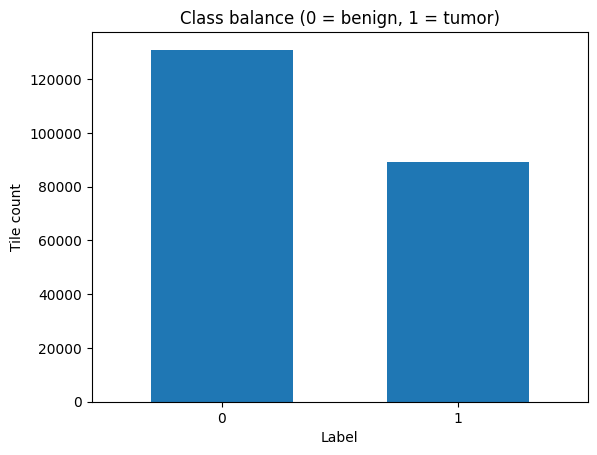

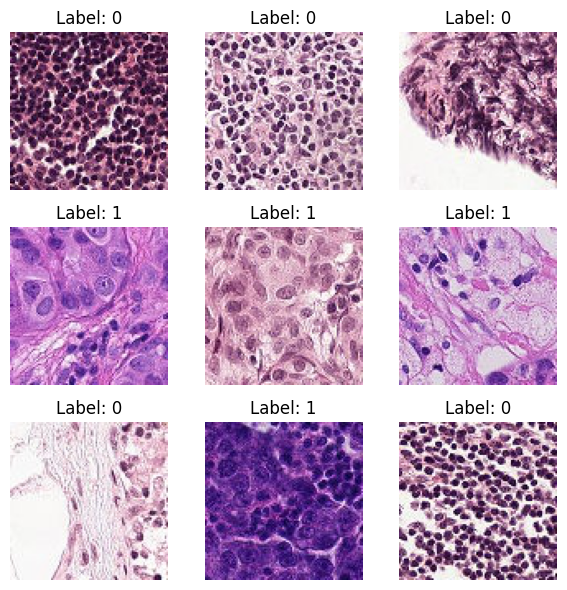

In [2]:
DATA_DIR = pathlib.Path("/workspace/data")
df       = pd.read_csv(DATA_DIR / "train_labels.csv")

# Class balance
df.label.value_counts().sort_index().plot.bar(rot=0, width=0.6)
plt.title("Class balance (0 = benign, 1 = tumor)")
plt.ylabel("Tile count"); plt.xlabel("Label")
plt.show()

# 3×3 sample grid
sample = random.sample(df.id.tolist(), 9)
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for ax, img_id in zip(axes.ravel(), sample):
    ax.imshow(Image.open(DATA_DIR / "train" / f"{img_id}.tif"))
    ax.set_title(f"Label: {int(df[df.id == img_id].label.values[0])}")
    ax.axis("off")
plt.tight_layout(); plt.show()

In [5]:
# Let us check if we have any broken files

broken = []
for p in tqdm(all_paths, desc="Verifying files"):
    try:
        img = Image.open(p)
        img.verify()
    except Exception:
        broken.append(p)

print(f"Unreadable/corrupted files: {len(broken)}")


Verifying files:  55%|█████▌    | 121653/220025 [17:06<17:48, 92.06it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
# Let us check if we have any files with zero bytes

zero_byte = []
for p in tqdm(all_paths, desc="Checking zero-byte files"):
    if os.path.getsize(p) == 0:
        zero_byte.append(p)

print(f"Found {len(zero_byte)} zero-byte files")

Checking zero-byte files: 100%|██████████| 220025/220025 [01:29<00:00, 2446.65it/s]

Found 0 zero-byte files


In [8]:
# Let us check if we have any duplicate files

hashes, dupes = {}, []
for p in tqdm(all_paths, desc="Checking duplicates"):
    h = hashlib.md5(p.read_bytes()).hexdigest()
    if h in hashes: dupes.append((hashes[h], p))
    else:            hashes[h] = p
print(f"Found {len(dupes)} duplicate pairs")

Checking duplicates:   3%|▎         | 7360/220025 [00:55<26:57, 131.47it/s]


KeyboardInterrupt: 

In [9]:
# Let us check that all the structural properties of the files are okay.

structural_issues = []

for p in tqdm(all_paths, desc="Checking structure"):
    with Image.open(p) as img:
        # #dimensions: expect 96×96
        size_ok = img.size == (96, 96)
        # #colormode: expect RGB
        mode_ok = img.mode == "RGB"
        # #datatype: expect uint8 pixels
        arr = np.array(img)
        dtype_ok = arr.dtype == np.uint8

        if not (size_ok and mode_ok and dtype_ok):
            structural_issues.append((p, img.size, img.mode, arr.dtype))

print(f"Found {len(structural_issues)} files with unexpected structure")

Checking structure:   1%|          | 2286/220025 [00:09<14:55, 243.11it/s]


KeyboardInterrupt: 

## Pre‑processing & Dataset class

In [11]:
# 1. Per-channel mean & std (1000-sample)
sample = random.sample(all_paths, 1000)
arr = np.stack([np.array(Image.open(p)) for p in sample])
print("Means:", arr.mean((0,1,2)), "Stds:", arr.std((0,1,2)))

Means: [179.37617893 139.5461059  178.20099566] Stds: [60.71819619 71.28088008 54.60289096]


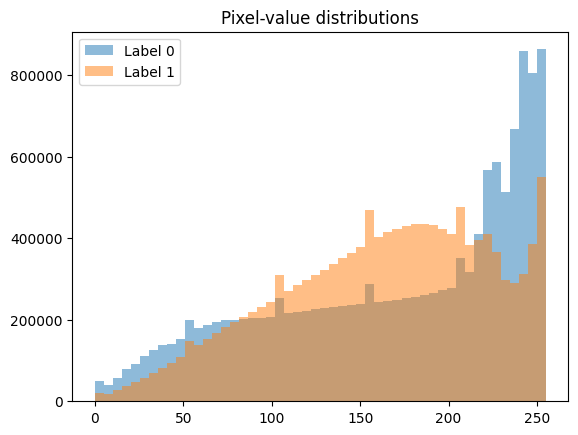

In [14]:
# 2. RGB histograms stratified by label (500/sample)
df['path'] = df['id'].apply(lambda i: DATA_DIR/'train'/f"{i}.tif")
for l in [0,1]:
    v = np.array([np.array(Image.open(p)).ravel()
                  for p in random.sample(df[df.label==l].path.tolist(), 500)]).ravel()
    plt.hist(v, bins=50, alpha=0.5, label=f"Label {l}")
plt.legend(); plt.title("Pixel‐value distributions"); plt.show()

Brightness outliers: 100


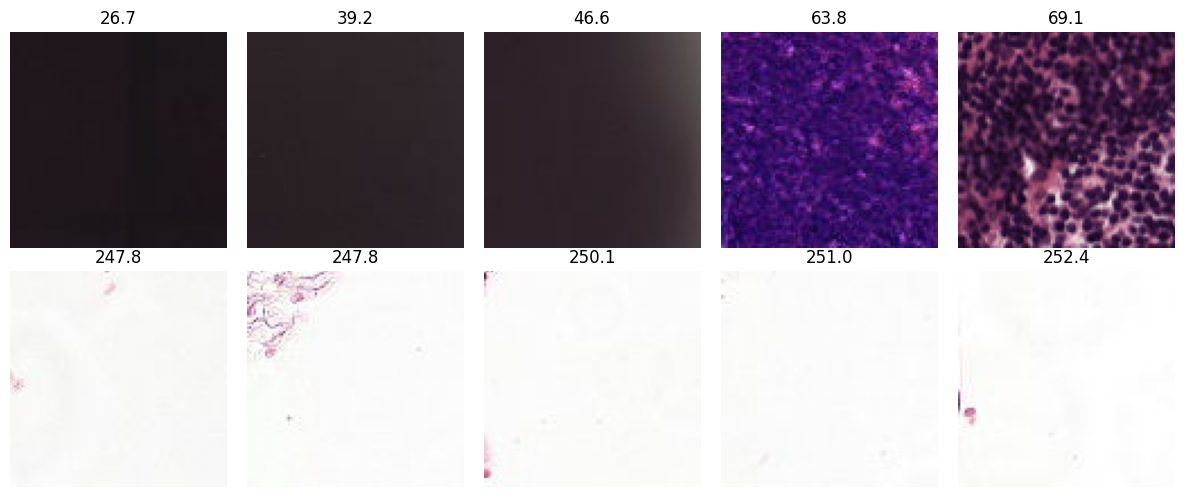

In [15]:
# 3. Brightness‐based outliers (1st/99th percentiles)
b = [(p, np.array(Image.open(p)).mean()) for p in random.sample(all_paths, 5000)]
lo, hi = np.percentile([val for _, val in b], [1, 99])
outliers = [p for p, val in b if val < lo or val > hi]
print("Brightness outliers:", len(outliers))


# 3.1. Sort by mean brightness
b_sorted = sorted(b, key=lambda x: x[1])
darkest, brightest = b_sorted[:5], b_sorted[-5:]

# 3.2. Plot
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for ax, (p, v) in zip(axs.ravel(), darkest + brightest):
    ax.imshow(Image.open(p)); ax.set_title(f"{v:.1f}"); ax.axis('off')
plt.tight_layout(); plt.show()

In [17]:
# 4. PCA on flattened pixels (1000-sample → 2D)
from sklearn.decomposition import PCA
sample = random.sample(all_paths, 1000)
data = np.array([np.array(Image.open(p)).flatten() for p in sample])
print("PCA shape:", PCA(2).fit_transform(data).shape)

PCA shape: (1000, 2)


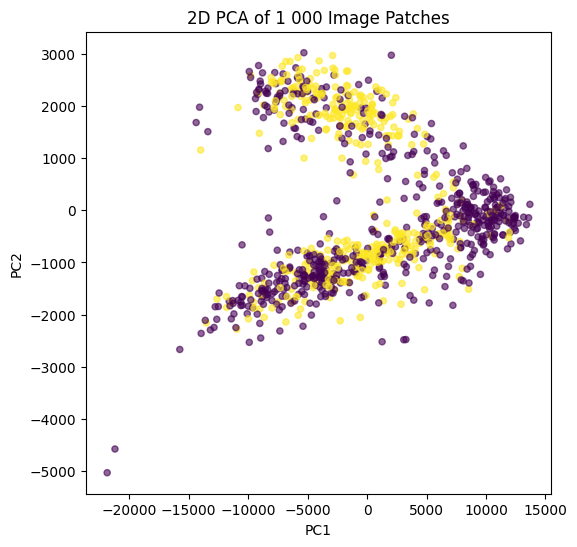

Explained variance ratio: [0.39024064 0.01838529]


In [20]:
# 2. Sample 1 000 patches
sample_paths = random.sample(all_paths, 1000)

# 3. Build a (1000, 96×96×3) → (1000, 27648) data matrix
data = np.stack([np.array(Image.open(p)).flatten() for p in sample_paths])

# 4. Fit PCA to 2 components and transform
pca = PCA(n_components=2)
coords = pca.fit_transform(data)

# 5. Grab labels
labels = [ df.loc[df.id == p.stem, 'label'].item() for p in sample_paths ]

# 6. Scatter-plot
plt.figure(figsize=(6, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=labels, alpha=0.6, s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of 1 000 Image Patches")
plt.show()

# 7. How much variance do these axes explain?
print("Explained variance ratio:", pca.explained_variance_ratio_)

## Baseline model – ResNet‑18

In [ ]:
# TODO: load pretrained ResNet‑18 and replace fc layer
pass

## Training loop & metrics

In [ ]:
# TODO: implement epoch loop, log loss & AUC to wandb
pass

## Experiment variants (Model‑1, Model‑2, …)

In [ ]:
# TODO: try deeper backbones / augmentations / samplers
pass

## Comparison & analysis

In [ ]:
# TODO: pull runs via wandb API and plot val AUCs
pass

## Submission & leaderboard

In [ ]:
# TODO: create submission.csv and submit via Kaggle CLI
pass

## Conclusions & next steps
*Key findings here.*

**TODO Week‑4:** …